In [1]:
import os
import requests
import json
import re
import pyttsx3
import random
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from inltk.inltk import get_sentence_encoding
from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.callbacks import EarlyStopping 
from keras.callbacks import ModelCheckpoint

In [2]:
# ENGLISH TO HINDI TRANSLATOR USING A PRIVATE AZURE SERVICE
subscription_key = '1352efe917df4167b7e990696200e04a'
endpoint =  'https://api.cognitive.microsofttranslator.com/'

path = '/translate?api-version=3.0'
params = '&from=en&to=hi'
constructed_url = endpoint + path + params

headers = {
    'Ocp-Apim-Subscription-Key': subscription_key,
    'Content-type': 'application/json',
    'Ocp-Apim-Subscription-Region': 'centralindia',
}

def translate(text):
    body = []
    count = 0
    if isinstance(text, list):
        for sent in text:
            body.append({'text': sent})
            count += len(sent)
            if count>10000:
                body.pop(-1)
                break
    else:
        body.append({'text': text})
    
    request = requests.post(constructed_url, headers=headers, json=body)
    response = request.json()
    
    if isinstance(text, list):
        try:
            return [result['translations'][0]['text'] for result in response]
        except:
            print(json.dumps(response,indent=2))
            print(body)
    else:
        return response[0]['translations'][0]['text']

translate('test')

'परीक्षा'

In [3]:
# TESTER FUNCTION FOR TRANSLATOR THAT COPIES TO CLIPBOARD
import pyperclip
result = translate(input())
print(result)
pyperclip.copy(result)

In [56]:
# READING ENGLISH DATASET
import pandas as pd
df = pd.read_json("./slimmed.json")
df.head()

,intent,text,responses,extension,context,entityType,entities
0,Greeting,"[Hi, Hi there, Hello, Hello there, Hya there]","[Hi human, Hello human]","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'GreetingUserRequest', 'clea...",NA,[]
1,GreetingResponse,"[My user is <HUMAN>, This is <HUMAN>, I am <HU...","[I am good! Hi <HUMAN>! How can I help?, I am ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 3, 'rangeTo'..."
2,CourtesyGreeting,"[How are you?, Hi how are you?, Hello how are ...","[Hello, I am good. thank you, how are you?, He...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'CourtesyGreetingUserRequest...",NA,[]
3,CourtesyGreetingResponse,"[Thanks! This is <HUMAN>, Thanks! I am <HUMAN>...","[Good! Hello <HUMAN>, how can I help you?, OK!...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 5, 'rangeTo'..."
4,CurrentHumanQuery,"[What is my name?, What do you call me?, Who d...","[You are <HUMAN>! How can I help?, Your name i...",{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'CurrentHumanQuery', 'clear'...",NA,[]


In [57]:
df['responses'].values

array([list(['Hi human', 'Hello human']),
       list(['I am good! Hi <HUMAN>! How can I help?', 'I am good! Hi <HUMAN>, how can I help you?', 'I am good! Hello <HUMAN>, what can I do for you?', 'I am good! hi <HUMAN>, what can I do for you?']),
       list(['Hello, I am good. thank you, how are you?', 'Hello, thank you, how are you?']),
       list(['Good! Hello <HUMAN>, how can I help you?', 'OK! Hello <HUMAN>, what can I do for you?']),
       list(['You are <HUMAN>! How can I help?', 'Your name is  <HUMAN>, how can I help you?', 'They call you <HUMAN>, what can I do for you?', 'Your name is <HUMAN>, how can I help you?', '<HUMAN>, what can I do for you?']),
       list(['You can call me Geni', 'You may call me Geni', 'Call me Geni']),
       list(['My name is GeniSys', 'GeniSys', 'My real name is GeniSys']),
       list(['One moment', 'One sec', 'One second']),
       list(['No problem!', 'Happy to help!', 'Any time!', 'My pleasure']), list(['OK', 'No problem', 'Right']),
       li

In [58]:
# INTENTS NEED TO BE SPLIT INTO SEPARATE WORDS TO BE PROPERLY TRANSLATED
def camel_case_split(str):
    return ' '.join(re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', str))

In [59]:
# SPLIT INTENTS AND TRANSLATE TO HINDI
df['intent'] = df['intent'].apply(camel_case_split)
df['intent'] = df['intent'].apply(translate)
df.head()

,intent,text,responses,extension,context,entityType,entities
0,शुभकामना,"[Hi, Hi there, Hello, Hello there, Hya there]","[Hi human, Hello human]","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'GreetingUserRequest', 'clea...",NA,[]
1,ग्रीटिंग रिस्पांस,"[My user is <HUMAN>, This is <HUMAN>, I am <HU...","[I am good! Hi <HUMAN>! How can I help?, I am ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 3, 'rangeTo'..."
2,सौजन्य अभिवादन,"[How are you?, Hi how are you?, Hello how are ...","[Hello, I am good. thank you, how are you?, He...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'CourtesyGreetingUserRequest...",NA,[]
3,सौजन्य ग्रीटिंग रिस्पांस,"[Thanks! This is <HUMAN>, Thanks! I am <HUMAN>...","[Good! Hello <HUMAN>, how can I help you?, OK!...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 5, 'rangeTo'..."
4,वर्तमान मानव क्वेरी,"[What is my name?, What do you call me?, Who d...","[You are <HUMAN>! How can I help?, Your name i...",{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'CurrentHumanQuery', 'clear'...",NA,[]


In [60]:
# NOW ALSO TRANSLATE TEXT AND RESPONSES
df['responses'] = df['responses'].apply(translate)
df['text'] = df['text'].apply(translate)
df.head()

,intent,text,responses,extension,context,entityType,entities
0,शुभकामना,"[नमस्ते, आपको नमस्कार, नमस्कार, आपको नमस्कार, ...","[हाय मानव, नमस्ते मानव]","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'GreetingUserRequest', 'clea...",NA,[]
1,ग्रीटिंग रिस्पांस,"[मेरा उपयोगकर्ता है<HUMAN>, यह है<HUMAN>, मैं ...",[मैं अच्छा/अच्छी हूँ! हाय <HUMAN>! मैं कैसे मद...,"{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 3, 'rangeTo'..."
2,सौजन्य अभिवादन,"[तुम कैसे हो?, नमस्ते क्या हालचाल है?, नमस्कार...","[हैलो, मैं अच्छा हूं। धन्यवाद, आप कैसे हैं?, न...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'CourtesyGreetingUserRequest...",NA,[]
3,सौजन्य ग्रीटिंग रिस्पांस,"[धन्यवाद! यह है<HUMAN>, धन्यवाद! मैं हूं<HUMAN...","[अच्छा! नमस्ते <HUMAN>, मैं आपकी मदद कैसे कर स...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 5, 'rangeTo'..."
4,वर्तमान मानव क्वेरी,"[मेरा नाम क्या है?, आप मुझे क्या कहते हैं?, आप...",[आप <HUMAN> रहे हैं! मैं कैसे मदद कर सकता हूं?...,{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'CurrentHumanQuery', 'clear'...",NA,[]


In [61]:
# SAVE FINAL HINDI DATASET
df.to_json(f'slimmed.json')

In [62]:
# READ HINDI DATASET
hdf = pd.read_json('slimmed.json')
hdf.head()

,intent,text,responses,extension,context,entityType,entities
0,शुभकामना,"[नमस्ते, आपको नमस्कार, नमस्कार, आपको नमस्कार, ...","[हाय मानव, नमस्ते मानव]","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'GreetingUserRequest', 'clea...",NA,[]
1,ग्रीटिंग रिस्पांस,"[मेरा उपयोगकर्ता है<HUMAN>, यह है<HUMAN>, मैं ...",[मैं अच्छा/अच्छी हूँ! हाय <HUMAN>! मैं कैसे मद...,"{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 3, 'rangeTo'..."
2,सौजन्य अभिवादन,"[तुम कैसे हो?, नमस्ते क्या हालचाल है?, नमस्कार...","[हैलो, मैं अच्छा हूं। धन्यवाद, आप कैसे हैं?, न...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'CourtesyGreetingUserRequest...",NA,[]
3,सौजन्य ग्रीटिंग रिस्पांस,"[धन्यवाद! यह है<HUMAN>, धन्यवाद! मैं हूं<HUMAN...","[अच्छा! नमस्ते <HUMAN>, मैं आपकी मदद कैसे कर स...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 5, 'rangeTo'..."
4,वर्तमान मानव क्वेरी,"[मेरा नाम क्या है?, आप मुझे क्या कहते हैं?, आप...",[आप <HUMAN> रहे हैं! मैं कैसे मदद कर सकता हूं?...,{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'CurrentHumanQuery', 'clear'...",NA,[]


In [63]:
# SEPARATE CLUBBED TEXT ROWS
intent = []
for field in hdf.values:
    for text in field[1]:
        intent.append({'intent':field[0], 'caption':text})
data = pd.DataFrame(intent)
data.head()

,intent,caption
0,शुभकामना,नमस्ते
1,शुभकामना,आपको नमस्कार
2,शुभकामना,नमस्कार
3,शुभकामना,आपको नमस्कार
4,शुभकामना,वहां हया


In [64]:
%%capture
# GET EMBEDDING OF SENTENCES
# inltk prints empty lines while encoding sentences so %%capture anulls that

X = []
for sent in data['caption']:
    X.append(get_sentence_encoding(sent,'hi'))

In [65]:
X = np.array(X)
X.shape

(103, 400)

In [66]:
# ONE HOT ENCODE LABELS FOR USE IN MODEL
ohe = OneHotEncoder()
le = LabelEncoder()
intents = le.fit_transform(data['intent'])
intents = intents.reshape(-1,1)
intents = ohe.fit_transform(intents).toarray()
intents.shape

(103, 17)

In [67]:
with open('pickles/ohe', 'wb+') as handle:
    pickle.dump(ohe, handle)
with open('pickles/le', 'wb+') as handle:
    pickle.dump(le, handle)

In [68]:
X = X.reshape(len(X),1,X.shape[1])
X.shape

(103, 1, 400)

In [69]:
X, y = shuffle(X, intents)

In [70]:
# BUILD MODEL
model = Sequential()
model.add(Bidirectional(LSTM(128), input_shape=(1, 400)))
model.add(Dropout(0.8))
model.add(Dense(intents.shape[1], activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 256)               541696    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 17)                4369      
Total params: 546,065
Trainable params: 546,065
Non-trainable params: 0
_________________________________________________________________


In [71]:
# TRAIN MODEL
filepath = "weights.best.hdf5"
cp_callback = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es_callback = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X, y,
                    epochs=100, 
                    validation_split=0.1,
                    batch_size=11,
                    verbose=0,
                    callbacks=[es_callback,cp_callback]
                   )


Epoch 00001: val_accuracy improved from -inf to 0.18182, saving model to weights.best.hdf5

Epoch 00002: val_accuracy improved from 0.18182 to 0.36364, saving model to weights.best.hdf5

Epoch 00003: val_accuracy did not improve from 0.36364

Epoch 00004: val_accuracy did not improve from 0.36364

Epoch 00005: val_accuracy did not improve from 0.36364

Epoch 00006: val_accuracy did not improve from 0.36364

Epoch 00007: val_accuracy did not improve from 0.36364

Epoch 00008: val_accuracy did not improve from 0.36364

Epoch 00009: val_accuracy improved from 0.36364 to 0.45455, saving model to weights.best.hdf5

Epoch 00010: val_accuracy did not improve from 0.45455

Epoch 00011: val_accuracy did not improve from 0.45455

Epoch 00012: val_accuracy did not improve from 0.45455

Epoch 00013: val_accuracy did not improve from 0.45455

Epoch 00014: val_accuracy did not improve from 0.45455

Epoch 00015: val_accuracy improved from 0.45455 to 0.54545, saving model to weights.best.hdf5

Epoch 

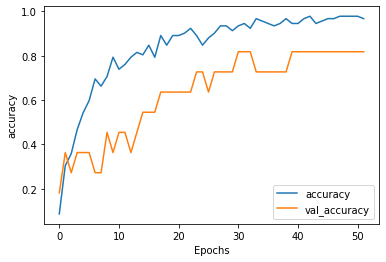

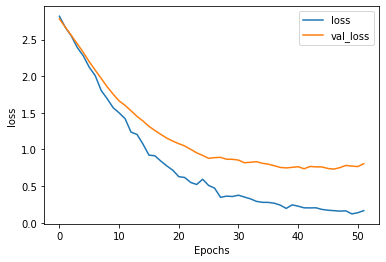

In [72]:
# PLOT TRAINING HISTORY

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [76]:
# LOAD BEST WEIGHTS STORED DURING TRAINING
model.load_weights("weights.best.hdf5")

In [77]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [75]:
import pyttsx3
reader = pyttsx3.init()
# print(list(map(lambda x: [x.id,x.gender]+x.languages, reader.getProperty('voices'))))

def say(text):
    for voice in reader.getProperty('voices'):
        if voice.languages[0]=='hi_IN' and voice.gender=='VoiceGenderFemale':
            reader.setProperty('voice', voice.id)
            reader.say(text)
            reader.runAndWait()
            reader.stop()

say('हेलो कैसे हो बेटा')

In [24]:
import keras
model = keras.models.load_model('model')

In [25]:
import pickle
with open('pickles/ohe', 'rb') as handle:
    ohe = pickle.load(handle)
with open('pickles/le', 'rb') as handle:
    le = pickle.load(handle)

In [26]:
# CHATBOT DEMO RUN
message = translate(input("Enter message: "))
print('Bot input:', message)

encoding = get_sentence_encoding(message,'hi').reshape(1,1,400)
result = ohe.inverse_transform(model.predict(encoding))
result = le.inverse_transform(result)[0]
choices = hdf[hdf['intent']==result]['responses'].to_list()[0]
response = random.choice(choices)

say(response)
print(response)

Enter message: 
Bot input: 


RuntimeError: stack expects a non-empty TensorList